In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from keras           import backend as K
from sklearn.model_selection import train_test_split

from lib.config                        import Config
from lib.model.toxic_comment_predictor import ToxicCommentPredictor
from lib.toxic_comment_tokenizer       import ToxicCommentTokenizer
from lib.model.utils                   import ToxicCommentPredictionPrinter
from lib.dataset_utils                 import load_dataset
import lib.embedding_utils as utils

Using TensorFlow backend.


In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

## Load train, validation and test samples

In [4]:
config = Config('./config.yml')

In [5]:
train_comments, train_labels, test_samples = load_dataset(config)

train_samples, validation_samples, train_labels, validation_labels = train_test_split(
    train_comments, 
    train_labels,
    test_size=0.3
)

print("Samples:\n\t- Train:",  len(train_samples), "\n\t- Validation: ", len(validation_samples), "\n\t- Test:", len(test_samples))
print(f'Comment: {train_samples[49]}\nCategories: {train_labels[49]}')

Samples:
	- Train: 111699 
	- Validation:  47872 
	- Test: 153164
Comment: {{unblock reviewed|1= I am telling you what truly happened I can only convince you I will be safer with my account in the future I believe my reason are reasonably I don't why   doubt my reason she or he did't even say why I don't think I will be unblock what ever reason I say please admins look at the reason I gave they are reasonable its is not complex I can't go further that because what happen was simple incident. I feel I am not going to be treated fairly.
Categories: [0 0 0 0 0 0]


### Create a tokenizer

In [ ]:
samples = np.concatenate((train_samples, validation_samples, test_samples))

tokenizer = ToxicCommentTokenizer(config, samples)

A tokenization convert comments to sequence of word indexes. It aboint to:
* Get an array of unrepeted words taken of all comments.
* Replace each word under a comments to his index.
* As result each comment is tranformed to an array of word indexes.

Also is necessary take each comment sequence and complet with zeros up to fixes size. As result all comment sequences have same len.

In [ ]:
paded_train_samples = tokenizer.texts_to_paded_sequences(train_samples)
paded_validation_samples = tokenizer.texts_to_paded_sequences(validation_samples)
paded_test_samples = tokenizer.texts_to_paded_sequences(test_samples)

In [ ]:
print("Paded comment sequence:\n\t", paded_train_samples[0])

In [ ]:
embedding_matrix = utils.build_embedding_matrix(
    embedding_file=config['word_embeding.path'],
    rows_count=config['word_embeding.rows_count'],
    columns_count=config['word_embeding.columns_count'],
    word_index=tokenizer.word_index()
)

In [ ]:
print("Word embedding shape: ", embedding_matrix.shape)

In [ ]:
print("Unrepeated words from all comments: ", len(tokenizer.word_index()))

### Create Model

In [ ]:
model = ToxicCommentPredictor(
    config, 
    embedding_matrix,
    validation_data=(paded_validation_samples, validation_labels),
    epochs=2,
    batch_size=32,
    lr=0.0001,
    dropout=0.2,
    recurrent_dropout=0.05
)
print(model.summary())

### Train Model

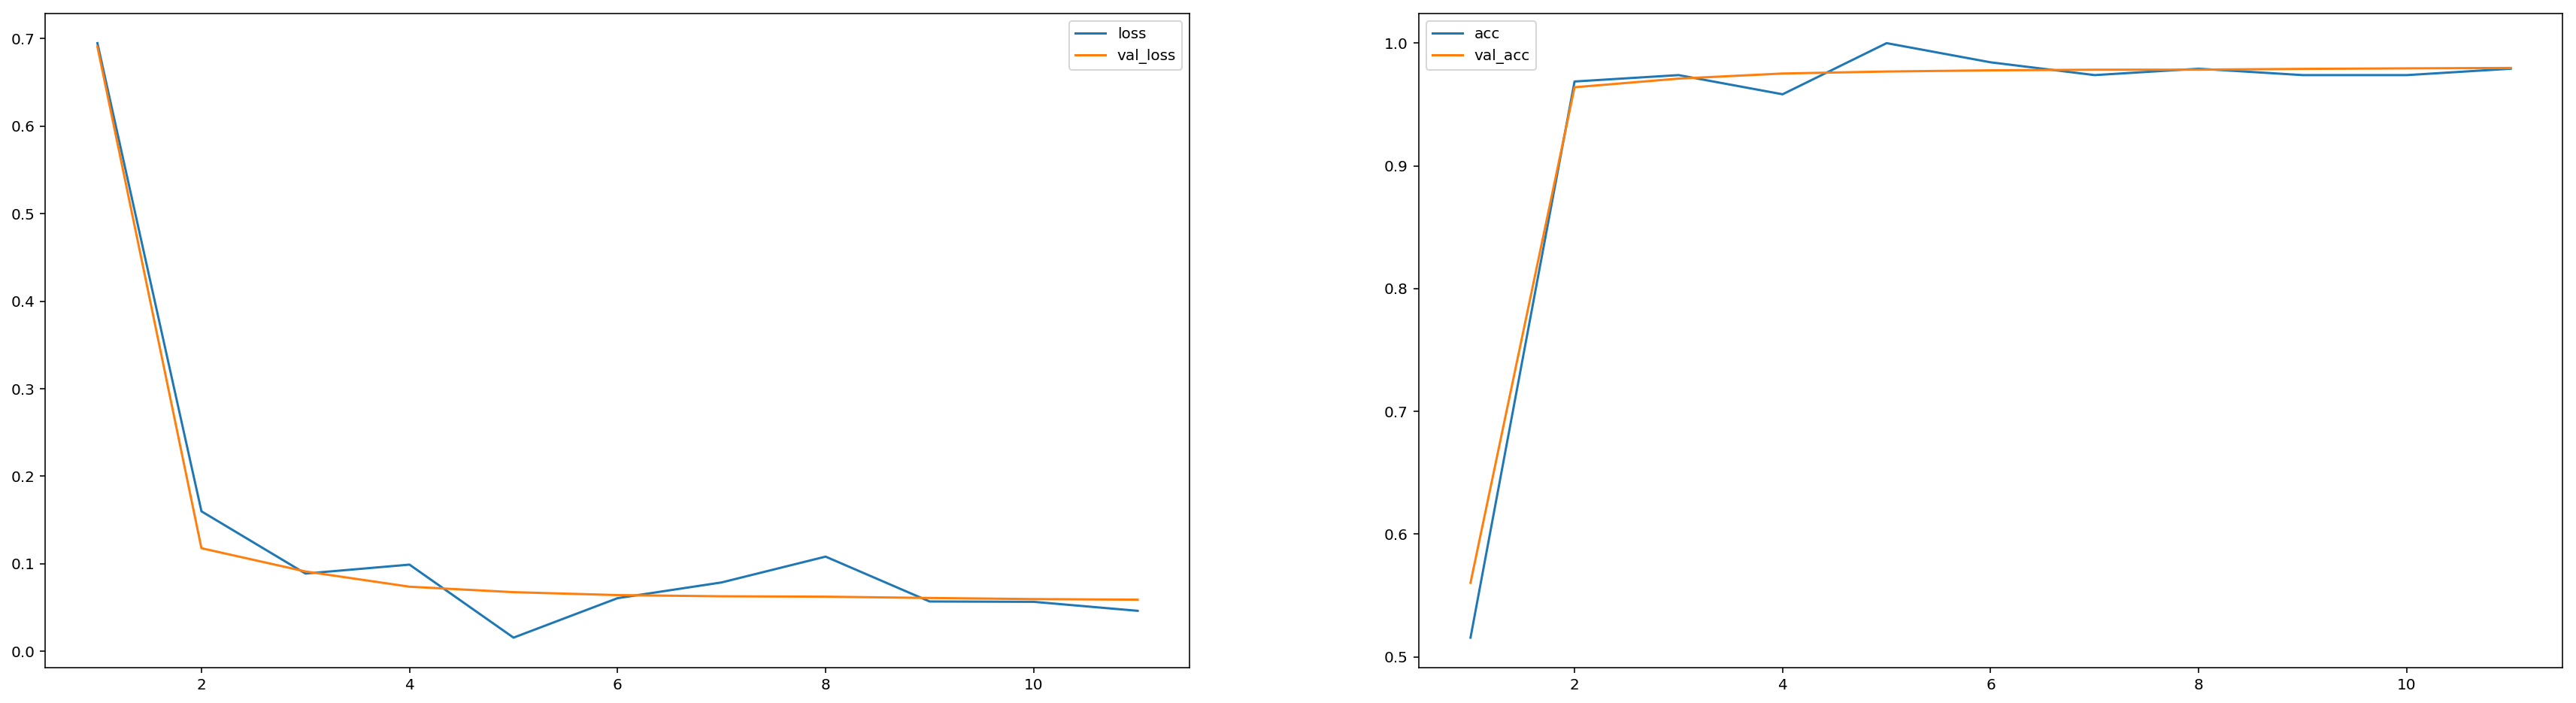

47872/47872 [==============================] - 45s 932us/step

Validation:
  - Loss (12): 0.058477 (⟱ 0.00051944)
  - Acc (12): 0.980013 (⟰ 0.00021933)
111699/111699 [==============================] - 663s 6ms/step - loss: 0.0646 - acc: 0.9780 - val_loss: 0.0581 - val_acc: 0.9800

Epoch 00002: val_loss improved from 0.06286 to 0.05814, saving model to best_weights.hdf5


In [26]:
model.fit(paded_train_samples, train_labels)

### Test model

In [ ]:
model.load_weights()
printer = ToxicCommentPredictionPrinter(model, tokenizer, config, paded_test_samples)

In [ ]:
printer.print_any()